In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM_0D as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM_0D as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 5 of the dataset in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v5_TNG-SIM_0D_Dataset.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 16)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [3]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [4]:
df_raw_log = log_df(df_raw)

In [5]:
df_raw_log.head(2)

,SubhaloBHMass_log,SubhaloBHMdot_log,SubhaloGasMetallicity_log,SubhaloSFRinRad_log,SubhaloStarMetallicity_log,SubhaloVelDisp_log,SubhaloVmax_log,SubhaloVmaxRad_log,SubhaloRgas_log,SubhaloRstar_log,SubhaloMgas_log,SubhaloMstar_log,GroupNsubs_log,Group_M_TopHat200_log,Group_R_TopHat200_log,SubhaloMHI_log,SubhaloMH2_log,Group_V_TopHat200_log,GroupSpin_dmo_log
0,9.998109,-3.400095,-2.112483,-0.708133,-1.543295,2.780947,2.999733,2.668073,2.949910,1.828096,13.092064,12.497443,4.235150,14.646987,3.292134,10.061858,10.043734,2.994161,-1.769689
1,9.898275,-4.012083,-2.359742,0.219496,-1.679031,2.774496,2.981978,3.134860,2.988572,2.098578,13.610459,12.316876,4.150971,14.687475,3.305635,9.899765,9.955786,3.007654,-1.893303


In [6]:
df_raw_log.shape

(21598, 19)

In [7]:
df_raw.shape

(21598, 19)

In [8]:
df_0D_log = log_df(df_0D)

In [9]:
df_0D_log.shape

(21598, 16)

In [10]:
df_0D.shape

(21598, 16)

In [11]:
df_0D_log.head(2)

,SubhaloGasMetallicity_log,SubhaloSFRinRad_log,SubhaloStarMetallicity_log,GroupNsubs_log,GroupSpin_dmo_log,SubhaloRstar_hs_log,SubhaloRgas_hs_log,SubhaloVmaxRad_hs_log,SubhaloVmax_hs_log,SubhaloVelDisp_hs_log,SubhaloMgas_hs_log,SubhaloMstar_hs_log,SubhaloBHMass_hs_log,SubhaloBHMdot_hs_log,SubhaloMHI_hs_log,SubhaloMH2_hs_log
0,-2.112483,-0.708133,-1.543295,4.235150,-1.769689,-1.464038,-0.342224,-0.624060,0.005572,-0.213213,-1.554922,-2.149543,-4.648685,-8.0,-4.584962,-4.603079
1,-2.359742,0.219496,-1.679031,4.150971,-1.893303,-1.207057,-0.317063,-0.170775,-0.025676,-0.233158,-1.077015,-2.370598,-4.788932,-8.0,-4.787443,-4.731455


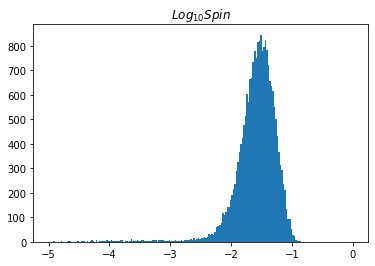

In [12]:
plt.hist(df_raw_log.GroupSpin_dmo_log, bins=200, range=(-5, 0))
plt.title(r'$Log_{10}Spin$')
plt.show()

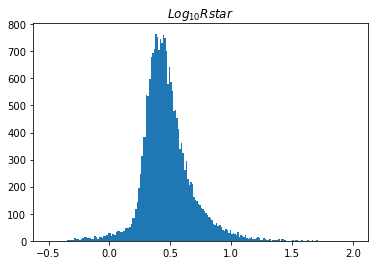

In [13]:
plt.hist(df_raw_log.SubhaloRstar_log, bins=200, range=(-0.5, 2.0))
plt.title(r'$Log_{10}Rstar$')
plt.show()

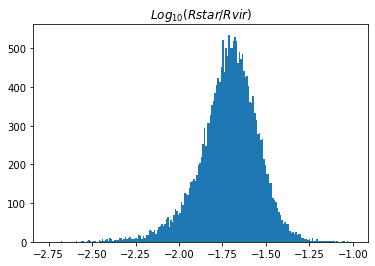

In [14]:
plt.hist(df_0D_log.SubhaloRstar_hs_log, bins=200, range=(-2.75, -1.0))
plt.title(r'$Log_{10}(Rstar/Rvir)$')
plt.show()

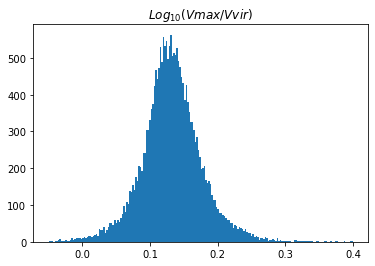

In [15]:
plt.hist(df_0D_log.SubhaloVmax_hs_log, bins=200, range=(-0.05, 0.4))
plt.title(r'$Log_{10}(Vmax/Vvir)$')
plt.show()

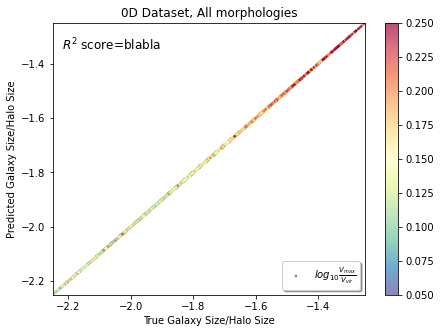

In [16]:
# Plot of 0D log10 Rstar vs 0D log10 Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D_log.SubhaloRstar_hs_log, df_0D_log.SubhaloRstar_hs_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.22, -1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
# ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title(r'0D Dataset, All morphologies')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

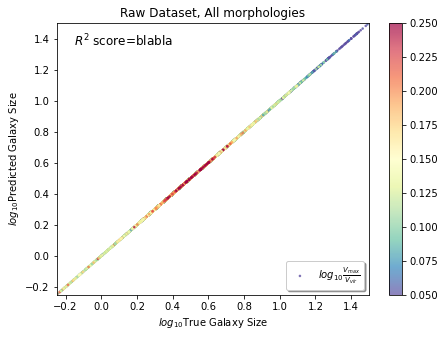

In [17]:
# Plot of log10 Raw Rstar vs log10 Raw Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, df_raw_log.SubhaloRstar_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, All morphologies')
ax.set_xlabel(r'$log_{10}$True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel(r'$log_{10}$Predicted Galaxy Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

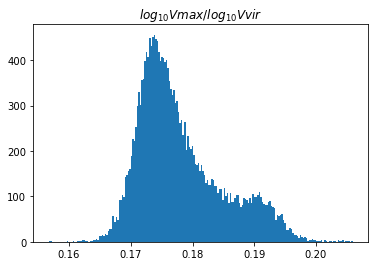

In [18]:
plt.hist(df_raw_log.SubhaloVmax_log/df_raw_log.Group_M_TopHat200_log, bins=200)
plt.title(r'$log_{10}Vmax/log_{10}Vvir$')
plt.show()

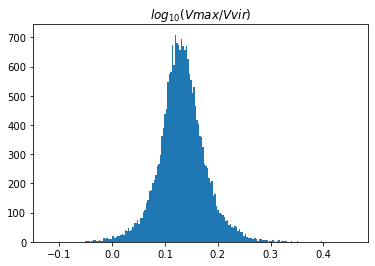

In [19]:
plt.hist(df_0D_log.SubhaloVmax_hs_log, bins=200)
plt.title(r'$log_{10}(Vmax/Vvir)$')
plt.show()

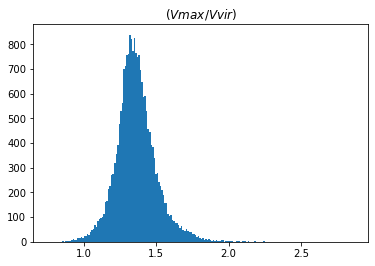

In [20]:
plt.hist(df_0D.SubhaloVmax_hs, bins=200)
plt.title(r'$(Vmax/Vvir)$')
plt.show()

### <font color='purple'> <a id =10> </a> <br> Complete 0D Dataset: SVR

In [21]:
X_all = df_0D_log.drop(columns=['SubhaloRstar_hs_log'])
 

y_all = df_0D_log.loc[:,'SubhaloRstar_hs_log']

In [25]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2],
              }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 3, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
elapsed_time_min = elapsed_time/60
print(f"Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset: {elapsed_time:.3f} seconds, {elapsed_time_min:.3f} minutes")

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV 1/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.744, test=0.748) total time=   5.8s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf;, score=(train=0.585, test=0.042) total time=  15.3s
[CV 2/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf;, score=(train=0.490, test=0.032) total time=  10.6s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=100, svr__kernel=rbf;, score=(train=0.267, test=-0.007) total time=   3.4s
[CV 3/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.780, test=0.787) total time=   8.0s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf;, score=(train=0.930, test=-0.002) total time=  32.6s
[CV 3/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf;, score=(train=0.773, test=0.042) total time=  17.4s
[CV 1/3] END svr__C=10.0, svr__epsilo

[CV 2/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.803, test=0.775) total time=   5.7s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf;, score=(train=0.804, test=0.643) total time=   7.6s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.740, test=0.743) total time=   2.5s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.737, test=0.745) total time=   2.4s
[CV 2/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=1.0, svr__kernel=rbf;, score=(train=0.750, test=0.604) total time=   3.3s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.710, test=0.699) total time=   0.6s
[CV 2/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.714, test=0.694) total time=   0.7s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.6

[CV 2/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.747, test=0.741) total time=   6.0s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf;, score=(train=0.565, test=-0.001) total time=  17.2s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf;, score=(train=0.493, test=0.032) total time=  10.8s
[CV 3/3] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=100, svr__kernel=rbf;, score=(train=0.265, test=-0.009) total time=   3.6s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf;, score=(train=0.940, test=0.694) total time=  22.9s
[CV 1/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.837, test=0.810) total time=   2.9s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.836, test=0.810) total time=   3.1s
[CV 3/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.8

[CV 3/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.745, test=0.748) total time=   6.1s
[CV 2/3] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf;, score=(train=0.566, test=-0.005) total time=  17.0s
[CV 1/3] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=100, svr__kernel=rbf;, score=(train=0.477, test=-0.000) total time=  11.5s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=scale, svr__kernel=rbf;, score=(train=0.850, test=0.820) total time=   8.7s
[CV 3/3] END svr__C=1.0, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf;, score=(train=0.939, test=0.675) total time=  26.8s
[CV 1/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.781, test=0.771) total time=   3.2s
[CV 3/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=0.01, svr__kernel=rbf;, score=(train=0.779, test=0.774) total time=   3.1s
[CV 2/3] END svr__C=1.0, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf;, score=(train=0.77

In [51]:
print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

Best params, best score: 0.8195 {'svr__C': 1.0, 'svr__epsilon': 0.05, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [52]:
print(f"Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset: {elapsed_time:.3f} seconds, {elapsed_time_min:.3f} minutes")

Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset: 17.990 seconds, 27.367 minutes


Fitting 3 folds for each of 25 candidates, totalling 225 fits
Best params, best score: 0.8195 {'svr__C': 1.0, 'svr__epsilon': 0.05, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM 0D Complete Dataset: 17.990 seconds, 27.367 minutes??



In [26]:
start_time = time.time()

best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 53 seconds ~ 1min to run this patch of code

Elapsed time to compute this patch of code: 24.138 seconds


In [27]:
start_time = time.time()

y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D Complete Dataset: {elapsed_time:.3f} seconds")

# It took 54 seconds ~ 1min to run this patch of code

Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on 0D Complete Dataset: 24.100 seconds


In [28]:
y_pred_SVR_df_all = pd.DataFrame({'y_pred_SVR SIM 0D': y_pred_SVR_all})

# y_pred_SVR_df_all.to_csv('TNG-SIM_images/v18_SVR_0D/v18_TNG-SIM_0D_AllDataset_y_pred_SVRwepsilon_predicted_sizes.csv', index=False)

# y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v18_SVR_0D/v18_TNG-SIM_0D_AllDataset_y_pred_SVRwepsilon_predicted_sizes.csv')

In [29]:
best_SVR_trainscore_all

0.8508891624874756

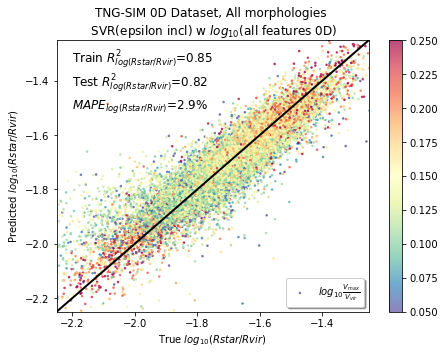

In [45]:
# Plot of Predicted log10 Rstar/Rvir vs True log 10 Rstar/Rvir

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D_log.SubhaloRstar_hs_log, y_pred_SVR_all,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.2, -1.5, r'Train $R^{2}_{log(Rstar/Rvir)}$=0.85' + '\n' + r'Test $R^{2}_{log(Rstar/Rvir)}$=0.82' + '\n' + r'$MAPE_{log(Rstar/Rvir)}$=2.9$\%$ ', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset, All morphologies \n ' + r'SVR(epsilon incl) w $log_{10}$(all features 0D) ')
ax.set_xlabel(r'True $log_{10}(Rstar/Rvir)$')
ax.set_ylabel(r'Predicted $log_{10}(Rstar/Rvir)$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v18_SVR_0D/v18_TNG-SIM_0D_AllDataset_SVRwepsilon_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

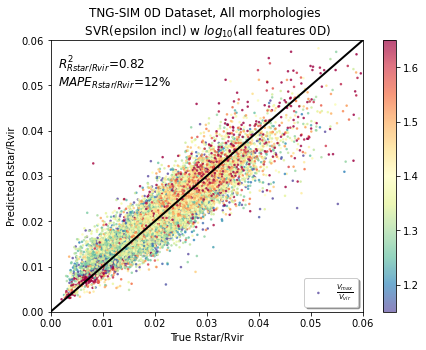

In [46]:
# Plot of Predicted Rstar/Rvir vs Rstar/Rvir 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_0D_log.SubhaloRstar_hs_log), 10**(y_pred_SVR_all),
            c = df_0D.SubhaloVmax_hs, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{V_{max}}{V_{vir}}$', vmin=1.15, vmax=1.65)
ax.text(0.0015, 0.05, r'$R^{2}_{Rstar/Rvir}$=0.82' + '\n' + r'$MAPE_{Rstar/Rvir}$=12$\%$ ', size=12)
ax.axis([0.0,0.06, 0.0,0.06])
ax.plot([-3.0, 1.0], [-3.0, 1.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset, All morphologies \n ' + r'SVR(epsilon incl) w $log_{10}$(all features 0D) ')
ax.set_xlabel(r'True Rstar/Rvir')
ax.set_ylabel(r'Predicted Rstar/Rvir')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v18_SVR_0D/v18_TNG-SIM_0D_AllDataset_SVRwepsilon_size_pred_colorlogVmaxVvir_2.jpeg', dpi=500)
plt.show()

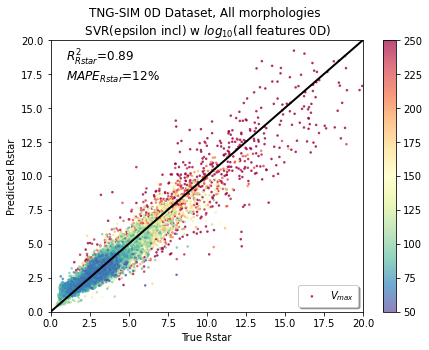

In [47]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw.SubhaloRstar, (10**(y_pred_SVR_all.loc[:, 'y_pred_SVR SIM 0D']))*df_raw.Group_R_TopHat200,
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 17, r'$R^{2}_{Rstar}$=0.89' + '\n' + r'$MAPE_{Rstar}$=12$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([-3.0, 30], [-3.0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM 0D Dataset, All morphologies \n ' + r'SVR(epsilon incl) w $log_{10}$(all features 0D) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v18_SVR_0D/v18_TNG-SIM_0D_AllDataset_SVRwepsilon_size_pred_colorlogVmaxVvir_3.jpeg', dpi=500)
plt.show()

### Other metrics

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

##### <font color='darkgreen'> <a id =10> </a> <br>log(Rstar/Rvir) metrics

In [31]:
r2_score(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.8243723823812633

In [32]:
mean_squared_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.005122744578004316

In [33]:
np.sqrt(mean_squared_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

0.07157335103238018

In [34]:
mean_absolute_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.05090686379821254

In [35]:
# MAPE in log scale
mean_absolute_percentage_error(df_0D_log.loc[:, 'SubhaloRstar_hs_log'], y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])

0.02944467808143781

##### <font color='darkgreen'> <a id =10> </a> <br>Rstar/Rvir metrics

In [36]:
r2_score(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

0.8243264056383035

In [37]:
mean_squared_error(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

1.0790226449682609e-05

In [38]:
np.sqrt(mean_squared_error(df_0D.loc[:, 'SubhaloRstar_hs'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])))

0.0032848480101341994

In [39]:
# MAPE in original variables
mean_absolute_percentage_error(10**(df_0D_log.loc[:, 'SubhaloRstar_hs_log']), 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D']))

0.12126240806312741

##### <font color='darkgreen'> <a id =10> </a> <br> Rstar metrics

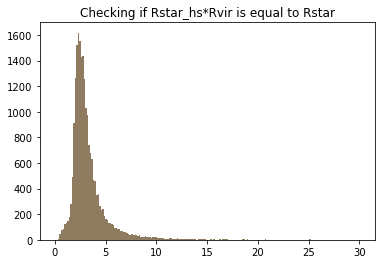

In [40]:
plt.hist(df_raw.loc[:, 'SubhaloRstar'], bins=200, range=(0,30))
plt.hist(df_0D.loc[:, 'SubhaloRstar_hs']*df_raw.Group_R_TopHat200, bins=200, range=(0,30), alpha=0.5)
plt.title('Checking if Rstar_hs*Rvir is equal to Rstar')

plt.show()

In [41]:
r2_score(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200)

0.8951763570014796

In [42]:
mean_squared_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200)

0.7851703279396809

In [43]:
np.sqrt(mean_squared_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200))

0.8860983737371833

In [44]:
mean_absolute_percentage_error(df_raw.loc[:, 'SubhaloRstar'], 10**(y_pred_SVR_all.loc[:,'y_pred_SVR SIM 0D'])*df_raw.Group_R_TopHat200)

0.1212625684947054

### <font color='purple'> <a id =3> </a> <br> SVR Learning Curve

In [48]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel(r"$R^{2}$ score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

Elapsed time to run SVR Learning Curves on the complete dataset: 17.990 seconds


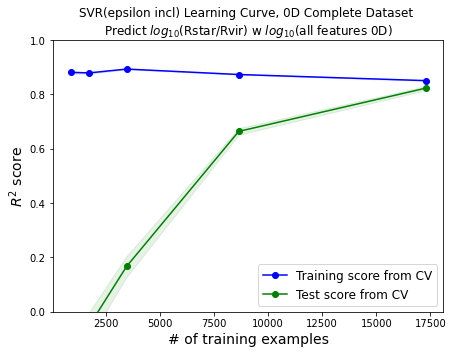

In [49]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR(epsilon incl) Learning Curve, 0D Complete Dataset \n'+r'Predict $log_{10}$(Rstar/Rvir) w $log_{10}$(all features 0D)', X_all, y_all, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the complete dataset: {elapsed_time:.3f} seconds")

In [50]:
# lc_all.savefig('TNG-SIM_images/v18_SVR_0D/v18_TNG-SIM_0D_AllDataset_SVRwepsilon_Learning_Curve.jpeg', dpi=500)